In [1]:
# import the necessary packages
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from scipy.stats import chi2_contingency as chisquare
import numpy as np
import cv2
import os
import sys
import pandas as pd

import configparser

sys.path.append(os.path.abspath('../Module'))
import preprocessing
import visualize

In [2]:
config = configparser.ConfigParser()
config.read('../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']

data_dir = vg_json_export + 'extracted_data/'


In [3]:
# https://www.pyimagesearch.com/2015/10/05/opencv-gamma-correction/
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")

	# apply gamma correction using the lookup table
	return cv2.LUT(image, table)

def gamma_correction(image):
    original = image
    # loop over various values of gamma
    for gamma in np.arange(0.0, 3.5, 0.5):
        # ignore when gamma is 1 (there will be no change to the image)
        if gamma == 1:
            continue

        # apply gamma correction and show the images
        gamma = gamma if gamma > 0 else 0.1
        adjusted = adjust_gamma(original, gamma=gamma)
        cv2.putText(adjusted, "g={}".format(gamma), (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 3)
        fig,ax=plt.subplots(figsize=(5,5))
        ax.imshow(np.flip(adjusted, axis=2))
        plt.show()
        
# https://www.pyimagesearch.com/2014/07/07/color-quantization-opencv-using-k-means-clustering/
# import the necessary packages
from sklearn.cluster import MiniBatchKMeans
def color_quantization(image, n=8):
    (h, w) = image.shape[:2]

    # convert the image from the RGB color space to the L*a*b*
    # color space -- since we will be clustering using k-means
    # which is based on the euclidean distance, we'll use the
    # L*a*b* color space where the euclidean distance implies
    # perceptual meaning
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    # reshape the image into a feature vector so that k-means
    # can be applied
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    # apply k-means using the specified number of clusters and
    # then create the quantized image based on the predictions
    clt = MiniBatchKMeans(n_clusters = n)
    labels = clt.fit_predict(image)
    quant = clt.cluster_centers_.astype("uint8")[labels]

    # reshape the feature vectors to images
    quant = quant.reshape((h, w, 3))

    # convert from L*a*b* to RGB
    quant = cv2.cvtColor(quant, cv2.COLOR_LAB2BGR)

    return quant

# get image data, plot

In [4]:
color_attributes = pd.read_csv(data_dir+"all_objects.csv", index_col=0)

/home/simeon/Dokumente/VisualGenome/images/3400.jpg
w: 800 h: 600
480000 pixel


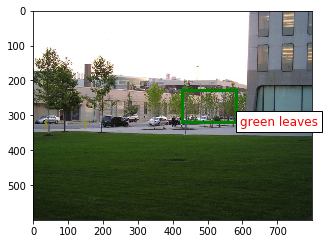

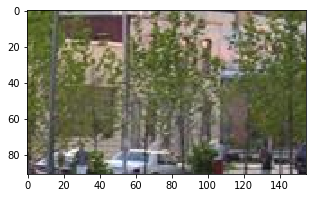

In [10]:
sample_image = color_attributes.sample(1).iloc[0]
filename = image_dir + str(sample_image.image_id) + '.jpg'
image = cv2.imread(filename)
print(filename)

img_height = image.shape[0]
img_width = image.shape[1]
print ('w:',img_width, 'h:',img_height)

pixel = img_width * img_height
print (pixel, 'pixel')

# Bounding Box
bb ={
    'h' : sample_image.bb_h,
    'w' : sample_image.bb_w,
    'x' : sample_image.bb_x,
    'y' : sample_image.bb_y,
    'label' : sample_image.color+' '+sample_image.object_name
}

# Bild plotten
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(np.flip(image,axis=2))
plt.text(bb['x']+bb['w']+10, bb['y']+bb['h']+10,bb['label'],fontsize=12,color='red',bbox=dict(facecolor='white'))
# BB hinzufügen
rect = patches.Rectangle((bb['x'],bb['y']),bb['w'],bb['h'],linewidth=3,edgecolor='green',facecolor='green',alpha=1,fill=False)
ax.add_patch(rect)
plt.show()

# Inhalt der BB
fig,ax=plt.subplots(figsize=(5,5))
img_bb = image[bb['y']:bb['y']+bb['h'], bb['x']:bb['x']+bb['w']]
ax.imshow(np.flip(img_bb, axis=2))
plt.show()

# Maske

p1 = (bb['x'], bb['y'])
p2 = (bb['x']+bb['w'], bb['y']+bb['h'])

mask = np.zeros(image.shape[:2], dtype="uint8")
cv2.rectangle(mask, p1, p2, (1,1,1), -1)
mask.shape

image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
ranges_lab = [0, 255, 0, 255, 0, 255]
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
ranges_hsv = [0, 179, 0, 255, 0, 255]
ranges_gbr = ranges_lab

## Gamma Correction

In [ ]:
for img in [image, img_bb]:
    img_gamma = adjust_gamma(img,gamma=2.4)
    # Bild plotten
    fig,ax = plt.subplots(figsize=(5,5))
    ax.imshow(np.flip(img_gamma,axis=2))
    plt.show

## Color Quantization

In [ ]:
img_quant = color_quantization(image,n=8)
img_bb_quant = color_quantization(img_bb,n=8)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
ax1.set_title('Original')
ax2.set_title('Original - Ausschnitt')
ax3.set_title('Color Quantization (ganzes Bild)')
ax4.set_title('Ganzes Bild - Ausschnitt')

ax6.set_title('Color Quantization (nur Ausschnitt)')
ax1.imshow(np.flip(image,axis=2))
ax2.imshow(np.flip(image[bb['y']:bb['y']+bb['h'], bb['x']:bb['x']+bb['w']],axis=2))
ax3.imshow(np.flip(img_quant,axis=2))
ax4.imshow(np.flip(img_quant[bb['y']:bb['y']+bb['h'], bb['x']:bb['x']+bb['w']],axis=2))

ax6.imshow(np.flip(img_bb_quant,axis=2))
plt.show

## 1 Kanal

In [ ]:
nbins = 64

chans = cv2.split(image)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
hist_channels = {}

# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and
    # concatenate the resulting histograms for each
    # channel
    hist = cv2.calcHist([chan], [0], mask, [nbins], [0, 255])
    hist_channels[color] = hist

for channel in hist_channels:
    # plot the histogram
    plt.plot(hist_channels[channel], color = channel)
    plt.xlim([0, nbins])

print ("flattened feature vector size: %d" % (np.array(hist_channels['b']).flatten().shape))

## 2d

In [ ]:
nbins = 32

# let's move on to 2D histograms -- I am reducing the
# number of bins in the histogram from 256 to 32 so we
# can better visualize the results
fig = plt.figure(figsize=(20,20))
 
# plot a 2D color histogram for green and blue
ax = fig.add_subplot(131)
hist = cv2.calcHist([chans[1], chans[0]], [0, 1], mask,
    [nbins, nbins], [0, 256, 0, 256])
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("2D Color Histogram for Green and Blue")
plt.colorbar(p)
 
# plot a 2D color histogram for green and red
ax = fig.add_subplot(132)
hist = cv2.calcHist([chans[1], chans[2]], [0, 1], mask,
    [nbins, nbins], [0, 256, 0, 256])
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("2D Color Histogram for Green and Red")
plt.colorbar(p)
 
# plot a 2D color histogram for blue and red
ax = fig.add_subplot(133)
hist = cv2.calcHist([chans[0], chans[2]], [0, 1], mask,
    [nbins, nbins], [0, 256, 0, 256])
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("2D Color Histogram for Blue and Red")
plt.colorbar(p)
 
# finally, let's examine the dimensionality of one of
# the 2D histograms
print (str(hist.ndim)+"D histogram shape: %s, with %d values" % (
    hist.shape, hist.flatten().shape[0]))

## 2d ab

In [ ]:
# convert to lab
image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab);


nbins = 16

# grab the image channels, initialize the tuple of colors,
# the figure and the flattened feature vector
l,a,b = cv2.split(image_lab)
channel_labels = ("l", "a", "b")

# let's move on to 2D histograms -- I am reducing the
# number of bins in the histogram from 256 to 32 so we
# can better visualize the results
fig = plt.figure(figsize=(20,20))
  
# plot a 2D color histogram for a and b
ax = fig.add_subplot(132)
hist = cv2.calcHist([a, b], [0, 1], mask,
    [nbins, nbins], [0, 256, 0, 256])
p = ax.imshow(hist, interpolation = "nearest")
ax.set_title("2D Color Histogram for a and b")
plt.colorbar(p)
 
# finally, let's examine the dimensionality of one of
# the 2D histograms
print (str(hist.ndim)+"D histogram shape: %s, with %d values" % (
    hist.shape, hist.flatten().shape[0]))

## 3d

In [16]:
nbins = 8

# our 2D histogram could only take into account 2 out
# of the 3 channels in the image so now let's build a
# 3D color histogram (utilizing all channels) with 8 bins
# in each direction -- we can't plot the 3D histogram, but
# the theory is exactly like that of a 2D histogram, so
# we'll just show the shape of the histogram
hist = cv2.calcHist([image], [0, 1, 2],
    mask, [nbins, nbins, nbins], [0, 256, 0, 256, 0, 256])
print (str(hist.ndim)+"D histogram shape: %s, with %d values" % (
    hist.shape, hist.flatten().shape[0]))

3D histogram shape: (8, 8, 8), with 512 values


In [24]:
rel_hist = np.divide(hist,pixel)
_bb = bb['h'],bb['w'], bb['x'],bb['y']
rel_hist.ravel() == preprocessing.get_histogram(filename = filename, bb = _bb, img_dir = image_dir, verbose='all', convert=False)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## relative instead of absolute values, ravel array

In [ ]:
rel_hist = np.divide(hist,pixel)
rel_hist = rel_hist.ravel()
rel_hist.shape

# durchschnittliche RGB-Werte

In [ ]:
df = pd.read_csv(data_dir+'all_objects.csv').rename(index=str, columns={'Unnamed: 0':'index'})#['bb_h bb_w bb_x bb_y color image_id object_id object_name'.split()]
df = df.sample(n=10000)

In [ ]:
df['rgb'] = df.apply(lambda x: preprocessing.mean_rgb_value(x,image_dir,verbose=False),axis=1)
df['rgb'] = df.apply(lambda x: x.rgb[:3], axis=1)
df.head(1)

In [ ]:
sample_image = df.sample(1).iloc[0]
filename = image_dir + str(sample_image.image_id) + '.jpg'
image = cv2.imread(filename)
img_height = image.shape[0]
img_width = image.shape[1]
pixel = img_width * img_height
bb ={'h' : sample_image.bb_h,'w' : sample_image.bb_w,'x' : sample_image.bb_x,'y' : sample_image.bb_y,'label' : sample_image.color+' '+sample_image.object_name}
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(np.flip(image,axis=2))
plt.text(bb['x']+bb['w']+10, bb['y']+bb['h']+10,bb['label'],fontsize=12,color='red',bbox=dict(facecolor='white'))
rect = patches.Rectangle((bb['x'],bb['y']),bb['w'],bb['h'],linewidth=3,edgecolor='green',facecolor='green',alpha=1,fill=False)
ax.add_patch(rect)
plt.title("Image w/ Object")
plt.show()
p1 = (bb['x'], bb['y'])
p2 = (bb['x']+bb['w'], bb['y']+bb['h'])
mask = np.zeros(image.shape[:2], dtype="uint8")
cv2.rectangle(mask, p1, p2, (1,1,1), -1)
mask.shape

# Plot RGB Color

fig,ax = plt.subplots(figsize=(5,5))
rgb_value = tuple(round(i)/255 for i in sample_image.rgb)
print ('rgb values: {raw}/{plt_format}'.format(raw=sample_image.rgb, plt_format=rgb_value))
rect = patches.Rectangle((0,0), 1, 1, color=rgb_value)
ax.add_patch(rect)
plt.title("RGB Color Patch")
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

# Plot Histogram

nbins = 64
chans = cv2.split(image)
colors = ("b", "g", "r")
plt.figure()
plt.title("'Flattened' Color Histogram")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
hist_channels = {}
for (chan, color) in zip(chans, colors):
    hist = cv2.calcHist([chan], [0], mask, [nbins], [0, 256])
    hist_channels[color] = hist
for channel in hist_channels:
    plt.plot(hist_channels[channel], color = channel)
    plt.xlim([0, nbins])

In [ ]:
for color in preprocessing.basic_colors():
    visualize.plot_in_hsv_chart(df.loc[df['color']==color].rgb.values, color_term = color,figsize=(10,5),xbins=64,ybins=10)

In [ ]:
sample_image = df.sample(1).iloc[0]
visualize.plot_vg_image(sample_image, image_dir)

print ('dominant colors')
dom_colors = preprocessing.dominant_colors(sample_image, 3, image_dir)
for c in dom_colors:
    visualize.plot_rgb_color(c)

    print ('average rgb')
mean_color = preprocessing.mean_rgb_value(sample_image, image_dir)
visualize.plot_rgb_color(mean_color)